# Sanushi detection workflow

This notebook shows an automated method or workflow to analyse the contents of a provided dataset of images tagged as either `sandwich` or `sushi`. The result is a list of filenames from the dataset that could potentially be considered as *Sanushi*, i.e. a combination of both types of snacks.

## Approach
The overall approach is to:

 1. train an image classifier on the provided dataset
   * Since the dataset is quite small (only about 800 images in total), we should reuse pre-trained models. In our case we choose Inception v3.
 2. assuming the trained model achieves sufficient performance, use the prediction outputs to find images which the model finds difficult to classify (presumably because the dish has aspects of both classes)
 
## `kmodel` library
In order to make this process easy to automate, I've developed various methods to help execute the approach described above, which can be found in folder `kmodel`. This is implemented using Keras.

## Download and extract dataset

In [1]:
base_dir = '/data/corpora/sanushi' # base folder for our data
all_dir = base_dir + '/sushi_or_sandwich' # folder for extracted dataset
keras_dir = base_dir + '/keras_data' # folder with split used for training

In [2]:
!wget http://research.us-east-1.s3.amazonaws.com/public/sushi_or_sandwich_photos.zip

--2019-01-22 15:08:04--  http://research.us-east-1.s3.amazonaws.com/public/sushi_or_sandwich_photos.zip
Resolving research.us-east-1.s3.amazonaws.com (research.us-east-1.s3.amazonaws.com)... 52.216.177.155
Connecting to research.us-east-1.s3.amazonaws.com (research.us-east-1.s3.amazonaws.com)|52.216.177.155|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94457826 (90M) [application/zip]
Saving to: ‘sushi_or_sandwich_photos.zip’

sushi_or_sandwich_p 100%[===================>]  90.08M  2.39MB/s    in 31s     

2019-01-22 15:08:41 (2.90 MB/s) - ‘sushi_or_sandwich_photos.zip’ saved [94457826/94457826]



In [3]:
!mkdir {base_dir}
!unzip sushi_or_sandwich_photos.zip -d {base_dir}

Archive:  sushi_or_sandwich_photos.zip
   creating: /data/corpora/sanushi/sushi_or_sandwich/
  inflating: /data/corpora/sanushi/sushi_or_sandwich/.DS_Store  
   creating: /data/corpora/sanushi/__MACOSX/
   creating: /data/corpora/sanushi/__MACOSX/sushi_or_sandwich/
  inflating: /data/corpora/sanushi/__MACOSX/sushi_or_sandwich/._.DS_Store  
   creating: /data/corpora/sanushi/sushi_or_sandwich/sandwich/
  inflating: /data/corpora/sanushi/sushi_or_sandwich/sandwich/train_1004.jpg  
  inflating: /data/corpora/sanushi/sushi_or_sandwich/sandwich/train_1009.jpg  
  inflating: /data/corpora/sanushi/sushi_or_sandwich/sandwich/train_1011.jpg  
  inflating: /data/corpora/sanushi/sushi_or_sandwich/sandwich/train_1038.jpg  
  inflating: /data/corpora/sanushi/sushi_or_sandwich/sandwich/train_1079.jpg  
  inflating: /data/corpora/sanushi/sushi_or_sandwich/sandwich/train_1198.jpg  
  inflating: /data/corpora/sanushi/sushi_or_sandwich/sandwich/train_1202.jpg  
  inflating: /data/corpora/sanushi/sushi_o

### Split dataset into test and validation for training

In [4]:
import kmodel.dataset as ds

In [5]:
ds.copy_as_keras_split(img_dir=all_dir, tgt_dir=keras_dir)

found 402 in /data/corpora/sanushi/sushi_or_sandwich/sushi
splitting at 40
test files 362
validations 40
removed  0 files from folder /data/corpora/sanushi/keras_data/valid/sushi
removed  0 files from folder /data/corpora/sanushi/keras_data/train/sushi
Copied 362 training files to  /data/corpora/sanushi/keras_data/train/sushi
Copied 40 validation files to  /data/corpora/sanushi/keras_data/valid/sushi
found 402 in /data/corpora/sanushi/sushi_or_sandwich/sandwich
splitting at 40
test files 362
validations 40
removed  0 files from folder /data/corpora/sanushi/keras_data/valid/sandwich
removed  0 files from folder /data/corpora/sanushi/keras_data/train/sandwich
Copied 362 training files to  /data/corpora/sanushi/keras_data/train/sandwich
Copied 40 validation files to  /data/corpora/sanushi/keras_data/valid/sandwich


('/data/corpora/sanushi/keras_data/train',
 '/data/corpora/sanushi/keras_data/valid')

## Create and Train model

Now that the dataset is in place, we are ready to create and train our model. The `kmodel` library already implements most of this and can be configured by passing it a dict with parameters to control the model creation and training.

In [2]:
import kmodel.kmodel as kmod

Using TensorFlow backend.


The main parameters used to configure `kmodel` are as follows (see `kmodel.sample_params` for an example and description of values)

In [3]:
model_params = {
    'num_classes': 2,
    'class_mode': 'categorical',
    'train_loss': 'categorical_crossentropy', # this should be appropriate for the top_activation
    'train_metrics': ['accuracy'],
    'batch_size': 16,
    'top': {
        'hidden_dense': [1024], # if using hidden layers, specify dimensions
        'hidden_dropout_rate': 0.2, # rate to use between top hidden layers
        'activation': 'softmax',
    },
    'top_train': { # top training phase
        'opt': 'adam',
        'epochs': 15,
        'checkpoint_path': 'cp.top.best.hdf5'
    },
    'fine_train': { # finetuning training phase
        'lr': 0.0001, 
        'momentum': 0.9,
        'epochs': 15,
        'checkpoint_path': 'cp.fine_tuned.best.hdf5'
        #'freeze_n_layers': 172 # optionally, specify how many layers to freeze
    },
    'checkpoint_path': 'final_weights.hdf5'
}

### Create the model
`kmodel` returns a model dictionary that provides access to the keras model, as well as to various parameters required for training in phases. We'll refer to that as `md` (short for *model dictionary*). When creating the model, `kmodel` creates a base model (which for now is hardcoded to be Inception V3 and downloads the pre-trained weights). This base model is then extended as specified in our `model_params` by adding a hidden layer and a final dense with softmax layer.

In [4]:
md = kmod.create_custom_model(model_params)

### Create batch generators to use during training
`kmodel` provides methods for creating batch generators for a given folder with images. Of course, the folders must adhere to the expected Keras structure. There are two methods for creating generators:

  * one for *training*, which performs some basic **data augmentation**
  * one for *validation*, which does not perform data augmentation, but performs basic scaling and pre-processing to adhere to the model's required input format.

In [5]:
train_generator = kmod.train_generator_for_dir('%s/train' % keras_dir, md)
validation_generator = kmod.validation_generator_for_dir('%s/valid' % keras_dir, md)

Found 724 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


### Training phase 1: train only the **top** layers
During this phase:
  * the pre-trained inception weights are frozen and only the newly added top layers are trained. This is especially needed in our case, since we only have a very limited number of images. 
  * the model is compiled and trained using the specified optimizer and epochs. 
  * the best performing weights are stored in the specified checkpoint.

(All specifications provided by `model_params`)
Depending on your machine, this may take a few minutes.

In [6]:
history_top = kmod.train_phase(md, phase='top', train_gen=train_generator, valid_gen=validation_generator)

Epoch 1/15
45/45 [==============================] - 13s 293ms/step - loss: 0.6239 - acc: 0.7180 - val_loss: 0.3724 - val_acc: 0.8375
Epoch 2/15
45/45 [==============================] - 12s 276ms/step - loss: 0.4146 - acc: 0.8278 - val_loss: 0.3017 - val_acc: 0.8625
Epoch 3/15
45/45 [==============================] - 12s 272ms/step - loss: 0.5291 - acc: 0.7735 - val_loss: 0.3066 - val_acc: 0.8875
Epoch 4/15
45/45 [==============================] - 12s 268ms/step - loss: 0.3079 - acc: 0.8750 - val_loss: 0.4887 - val_acc: 0.7875
Epoch 5/15
45/45 [==============================] - 12s 269ms/step - loss: 0.4119 - acc: 0.8139 - val_loss: 0.3919 - val_acc: 0.8250
Epoch 6/15
45/45 [==============================] - 12s 267ms/step - loss: 0.3573 - acc: 0.8222 - val_loss: 0.3135 - val_acc: 0.8625
Epoch 7/15
45/45 [==============================] - 12s 272ms/step - loss: 0.2846 - acc: 0.8819 - val_loss: 0.2710 - val_acc: 0.9125
Epoch 8/15
45/45 [==============================] - 12s 261ms/step - 

#### Verify model performance
The output of the previous step should give you an idea of whether the model performed well or not. In my experiments, the models achieve somewhere between 85 and 90% accuracy.
In practice, you can also monitor the performance using tensorboard (summaries are written to the `logs` folder), or by plotting or inspecting the training history like we do next.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history, figsize=(6,6), metric='acc'):
    hist = pd.DataFrame(history.history)
    plt.figure(figsize=(6,6))
    plt.plot(hist[metric])
    plt.plot(hist["val_%s" % metric])
    plt.legend()

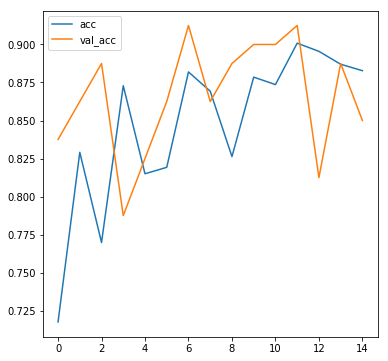

In [8]:
plot_history(history_top)

This type of inspection can show whether the model is overfitting (not our case) and can be used to change some hyperparameters (e.g. add further hidden layers, play with the dropout rate).

### Training phase 2: fine-tuning by training about half the layers
During this phase:
  * the bottom half of the layers in the model are frozen; this can improve performance. 
  * the model is compiled and trained using the specified optimizer and epochs. 
  * the best performing weights are stored in a specified checkpoint.

(All specifications provided by `model_params`)
Depending on your machine, this may take a few minutes.

In [10]:
import importlib
importlib.reload(kmod)

<module 'kmodel.kmodel' from '/home/rdenaux/nbs/rdenaux/cookpad2/kmodel/kmodel.py'>

In [11]:
history_fit = kmod.train_phase(md, phase='fine', train_gen=train_generator, valid_gen=validation_generator)

Freezing bottom 172 layers (of 315)
Epoch 1/15
45/45 [==============================] - 14s 310ms/step - loss: 0.2209 - acc: 0.9180 - val_loss: 0.2187 - val_acc: 0.9375
Epoch 2/15
45/45 [==============================] - 12s 278ms/step - loss: 0.2220 - acc: 0.9099 - val_loss: 0.2053 - val_acc: 0.9250
Epoch 3/15
45/45 [==============================] - 12s 275ms/step - loss: 0.1948 - acc: 0.9264 - val_loss: 0.1945 - val_acc: 0.9375
Epoch 4/15
45/45 [==============================] - 12s 273ms/step - loss: 0.1528 - acc: 0.9416 - val_loss: 0.1898 - val_acc: 0.9500
Epoch 5/15
45/45 [==============================] - 12s 266ms/step - loss: 0.1627 - acc: 0.9364 - val_loss: 0.1865 - val_acc: 0.9375
Epoch 6/15
45/45 [==============================] - 12s 273ms/step - loss: 0.1479 - acc: 0.9514 - val_loss: 0.1763 - val_acc: 0.9500
Epoch 7/15
45/45 [==============================] - 12s 271ms/step - loss: 0.1387 - acc: 0.9529 - val_loss: 0.1706 - val_acc: 0.9375
Epoch 8/15
45/45 [===============

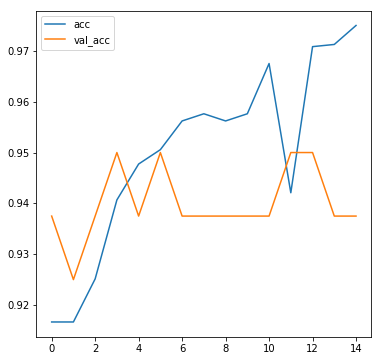

In [12]:
plot_history(history_fit)

In this case, finetuning further improved the model to reach an accuracy between 90 and 95%. However, the model has tended towards overfitting, so it'd be better to only fine-tune for about 5 epochs instead of the 15 we used here.

## Find candidates
Now that we have a trained model with good accuracy, we can use it to find candidate sanushis. `kmodel` has a module `candidates` which helps us with that.
Method `predict_table` creates rows for each of the files in a generator with:
  * information about the file, 
  * the actual tag 
  * the softmax predictions for the predicted tags
  
We put this into a pandas DataFrame for easier manipulation.

In [13]:
import kmodel.candidates as kcand

In [14]:
all_generator = kmod.validation_generator_for_dir(all_dir, md)
pt = pd.DataFrame(kcand.predict_table(md['model'], all_generator))

Found 804 images belonging to 2 classes.


In [15]:
pt[:2]

,a_sandwich,a_sushi,d,f,p_sandwich,p_sushi
0,1.0,0.0,/data/corpora/sanushi/sushi_or_sandwich,sandwich/train_1004.jpg,0.998820,0.001180
1,0.0,1.0,/data/corpora/sanushi/sushi_or_sandwich,sandwich/train_1009.jpg,0.549744,0.450256


The next step is to combine the softmax scores in a way that helps us find possible sanushi combinations, `kmodel` provides method `abs_p_diff` which calculates the absolute difference between two predictions, we put this value into column 'sanushi'.

In [16]:
pt['sanushi'] = kcand.abs_p_diff(pt, categA='sandwich', categB='sushi')

Finally, now that we have a table with a score for sanushi, we can show some of the most likely sanushi using method `plot_top_candidates`:

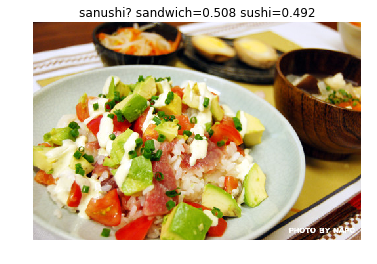

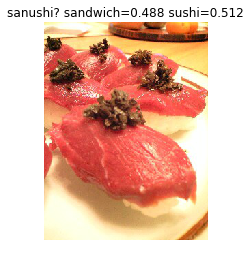

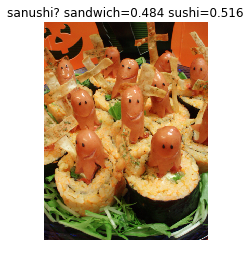

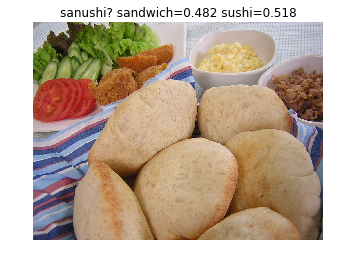

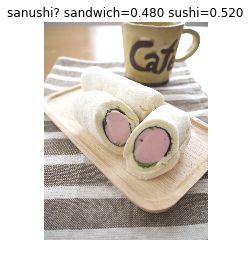

In [21]:
kcand.plot_top_candidates(pt, sort_field='sanushi', categA='sandwich', categB='sushi', k=5, p=0)

### Justification and workflow output
 * The softmax activation distributes the values in the final nodes in such a way that the sum is 1.
 * For our binary case, this means that values close to 0.5 mean that the model is uncertain about whether to classify the image as either sandwich or sushi.
 * Also, since the model is quite accurate, we expect most examples will "clearly" be assigned one category or the other, hence the absolute difference will be close to 1.
 * Since we don't have more information, we can simply sort the table by the *sanushi* value in ascending order. Those images with lowest value are the most likely candidates.
 
We can verify that this is a sensible approach by plotting the *sanushi* values.

In [22]:
def plot_pdiffs(df, field_name):
    plt.plot(df.sort_values(by=[field_name], ascending=True)[field_name].values)

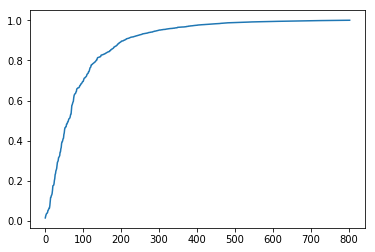

In [23]:
plot_pdiffs(pt, 'sanushi')

The graph shows that of the 800 images, most have a sanushi score of 0.8 or higer. About a 100 have a lower score; we could define a threshold (e.g. 0.4) but by simply returning the top k, we achieve something similar.
In terms of the output of the workflow, we can write the output table to a csv or similar. E.g.

In [27]:
pt.sort_values(by=['sanushi'], ascending=True)[:20]['f'].to_csv('sanushi_candidates.csv')